In [2]:
import numpy as np

data_path = "../02_Data/Processed/sp500_model_data_window30.npz"

npz = np.load(data_path, allow_pickle=True)

print("Keys in file:", npz.files)

X_train = npz["X_train"]
y_train = npz["y_train"]
X_val = npz["X_val"]
y_val = npz["y_val"]
X_test = npz["X_test"]
y_test = npz["y_test"]

feature_cols = npz["feature_cols"]
window_size = int(npz["window_size"])

print("Window size:", window_size)
print("Number of features:", X_train.shape[2])
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("First few feature names:", feature_cols[:10])


Keys in file: ['window_size', 'feature_cols', 'X_train', 'y_train', 'dates_train', 'X_val', 'y_val', 'dates_val', 'X_test', 'y_test', 'dates_test']
Window size: 30
Number of features: 13
Train shape: (706, 30, 13) (706,)
Val shape: (250, 30, 13) (250,)
Test shape: (488, 30, 13) (488,)
First few feature names: ['Close' 'High' 'Low' 'Open' 'Volume' 'log_return' 'ma_5' 'ma_20'
 'rolling_vol_20' 'sentiment_mean']


In [3]:
import numpy as np
import pandas as pd

from pathlib import Path

import sys
sys.path.append("../04_Src")  # so we can import our modules

import torch
from torch.utils.data import TensorDataset, DataLoader

from models.forecasting_model import LSTMForecastingModel
from evaluation.metrics import regression_metrics, format_metrics

from evaluation.metrics import regression_metrics

data_path = "../02_Data/Processed/sp500_model_data_window30.npz"

npz = np.load(data_path, allow_pickle=True)

X_train = npz["X_train"]
y_train = npz["y_train"]
X_val = npz["X_val"]
y_val = npz["y_val"]
X_test = npz["X_test"]
y_test = npz["y_test"]

feature_cols = npz["feature_cols"]
window_size = int(npz["window_size"])

print("Window size:", window_size)
print("Number of features:", X_train.shape[2])
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("First few feature names:", feature_cols[:10])


Window size: 30
Number of features: 13
Train shape: (706, 30, 13) (706,)
Val shape: (250, 30, 13) (250,)
Test shape: (488, 30, 13) (488,)
First few feature names: ['Close' 'High' 'Low' 'Open' 'Volume' 'log_return' 'ma_5' 'ma_20'
 'rolling_vol_20' 'sentiment_mean']


In [4]:
feature_cols_list = [str(c) for c in feature_cols]
print("Feature columns:", feature_cols_list)

log_return_index = feature_cols_list.index("log_return")
print("Index of log_return in feature dimension:", log_return_index)


Feature columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'ma_5', 'ma_20', 'rolling_vol_20', 'sentiment_mean', 'sentiment_pos_mean', 'sentiment_neg_mean', 'news_count']
Index of log_return in feature dimension: 5


In [5]:
# Baseline one: predict next return = last observed return in the window
last_returns_test = X_test[:, -1, log_return_index]
y_pred_naive = last_returns_test

metrics_naive = regression_metrics(y_test, y_pred_naive)
metrics_naive


{'mae': 0.00986573769000976,
 'rmse': 0.014724061388990689,
 'directional_accuracy': 0.49385245901639346}

In [6]:
last_returns_val = X_val[:, -1, log_return_index]
y_pred_naive_val = last_returns_val

metrics_naive_val = regression_metrics(y_val, y_pred_naive_val)
metrics_naive_val


{'mae': 0.009149708786975696,
 'rmse': 0.011460160549923139,
 'directional_accuracy': 0.48}

In [7]:
# Baseline two: predict next return = mean of last 5 log returns in the window

def rolling_mean_baseline(X, log_return_idx, window_tail=5):
    # X shape: (samples, window_size, num_features)
    # We take the last "window_tail" steps of log_return and compute their mean
    log_returns_segment = X[:, -window_tail:, log_return_idx]
    return log_returns_segment.mean(axis=1)

y_pred_ma5_test = rolling_mean_baseline(X_test, log_return_index, window_tail=5)
metrics_ma5 = regression_metrics(y_test, y_pred_ma5_test)
metrics_ma5


{'mae': 0.007425175713441336,
 'rmse': 0.011315619647611063,
 'directional_accuracy': 0.5102459016393442}

In [8]:
y_pred_ma5_val = rolling_mean_baseline(X_val, log_return_index, window_tail=5)
metrics_ma5_val = regression_metrics(y_val, y_pred_ma5_val)
metrics_ma5_val


{'mae': 0.007177495266604542,
 'rmse': 0.00906796341729078,
 'directional_accuracy': 0.516}

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Flatten the time dimension: (samples, window_size, num_features) -> (samples, window_size * num_features)
def flatten_sequences(X):
    n_samples, w_size, n_features = X.shape
    return X.reshape(n_samples, w_size * n_features)

X_train_flat = flatten_sequences(X_train)
X_val_flat = flatten_sequences(X_val)
X_test_flat = flatten_sequences(X_test)

print("Flattened shapes:")
print("Train:", X_train_flat.shape)
print("Val:  ", X_val_flat.shape)
print("Test: ", X_test_flat.shape)


Flattened shapes:
Train: (706, 390)
Val:   (250, 390)
Test:  (488, 390)


In [10]:
linreg_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression()),
    ]
)

linreg_pipeline.fit(X_train_flat, y_train)

y_pred_lin_val = linreg_pipeline.predict(X_val_flat)
y_pred_lin_test = linreg_pipeline.predict(X_test_flat)

metrics_lin_val = regression_metrics(y_val, y_pred_lin_val)
metrics_lin_test = regression_metrics(y_test, y_pred_lin_test)

metrics_lin_val, metrics_lin_test


({'mae': 0.008873289555253358,
  'rmse': 0.010976856363987531,
  'directional_accuracy': 0.472},
 {'mae': 0.014376251572824477,
  'rmse': 0.020164945455263674,
  'directional_accuracy': 0.4918032786885246})

In [11]:
baseline_results = pd.DataFrame(
    {
        "model": ["naive_last_return", "ma5_last_returns", "linear_regression"],
        "val_mae": [
            metrics_naive_val["mae"],
            metrics_ma5_val["mae"],
            metrics_lin_val["mae"],
        ],
        "val_rmse": [
            metrics_naive_val["rmse"],
            metrics_ma5_val["rmse"],
            metrics_lin_val["rmse"],
        ],
        "val_directional_accuracy": [
            metrics_naive_val["directional_accuracy"],
            metrics_ma5_val["directional_accuracy"],
            metrics_lin_val["directional_accuracy"],
        ],
        "test_mae": [
            metrics_naive["mae"],
            metrics_ma5["mae"],
            metrics_lin_test["mae"],
        ],
        "test_rmse": [
            metrics_naive["rmse"],
            metrics_ma5["rmse"],
            metrics_lin_test["rmse"],
        ],
        "test_directional_accuracy": [
            metrics_naive["directional_accuracy"],
            metrics_ma5["directional_accuracy"],
            metrics_lin_test["directional_accuracy"],
        ],
    }
)

baseline_results


,model,val_mae,val_rmse,val_directional_accuracy,test_mae,test_rmse,test_directional_accuracy
0,naive_last_return,0.009150,0.011460,0.480,0.009866,0.014724,0.493852
1,ma5_last_returns,0.007177,0.009068,0.516,0.007425,0.011316,0.510246
2,linear_regression,0.008873,0.010977,0.472,0.014376,0.020165,0.491803


In [12]:
results_path = "../05_Results/baseline_metrics.csv"
baseline_results.to_csv(results_path, index=False)
results_path


'../05_Results/baseline_metrics.csv'

### Baseline model summary

In [13]:
from evaluation.metrics import format_metrics

print("Validation metrics")
print(format_metrics(metrics_naive_val, prefix="Naive last return"))
print(format_metrics(metrics_ma5_val, prefix="MA5 last returns"))
print(format_metrics(metrics_lin_val, prefix="Linear regression"))

print("\nTest metrics")
print(format_metrics(metrics_naive, prefix="Naive last return"))
print(format_metrics(metrics_ma5, prefix="MA5 last returns"))
print(format_metrics(metrics_lin_test, prefix="Linear regression"))

Validation metrics
Naive last return: mae=0.009150, rmse=0.011460, directional_accuracy=0.480000
MA5 last returns: mae=0.007177, rmse=0.009068, directional_accuracy=0.516000
Linear regression: mae=0.008873, rmse=0.010977, directional_accuracy=0.472000

Test metrics
Naive last return: mae=0.009866, rmse=0.014724, directional_accuracy=0.493852
MA5 last returns: mae=0.007425, rmse=0.011316, directional_accuracy=0.510246
Linear regression: mae=0.014376, rmse=0.020165, directional_accuracy=0.491803


### First LSTM model test

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_features = X_train.shape[2]
seq_len = X_train.shape[1]

model = LSTMForecastingModel(
    num_features=num_features,
    hidden_size=64,
    num_layers=2,
    dropout=0.1,
).to(device)

print("Model parameter count:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Using device: cpu
Model parameter count: 53569


In [15]:
# Convert a small batch of training data to tensors
batch_size = 32

X_batch = torch.tensor(X_train[:batch_size], dtype=torch.float32).to(device)
y_batch = torch.tensor(y_train[:batch_size], dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred_batch = model(X_batch)

print("X_batch shape:", X_batch.shape)
print("y_batch shape:", y_batch.shape)
print("y_pred_batch shape:", y_pred_batch.shape)


X_batch shape: torch.Size([32, 30, 13])
y_batch shape: torch.Size([32])
y_pred_batch shape: torch.Size([32])


### LSTM dataset and data loaders


In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert numpy arrays to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


Using device: cpu


(12, 4, 8)

### LSTM training and evaluation functions


In [17]:
from models.forecasting_model import LSTMForecastingModel
from evaluation.metrics import regression_metrics, format_metrics


def train_one_epoch(
    model: torch.nn.Module,
    data_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device: torch.device,
) -> float:
    model.train()
    total_loss = 0.0
    num_batches = 0

    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / max(num_batches, 1)


@torch.no_grad()
def evaluate_model(
    model: torch.nn.Module,
    data_loader: DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
) -> tuple[float, np.ndarray, np.ndarray]:
    model.eval()
    total_loss = 0.0
    num_batches = 0

    all_true = []
    all_pred = []

    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        total_loss += loss.item()
        num_batches += 1

        all_true.append(y_batch.cpu().numpy())
        all_pred.append(y_pred.cpu().numpy())

    avg_loss = total_loss / max(num_batches, 1)

    if all_true:
        y_true = np.concatenate(all_true)
        y_pred = np.concatenate(all_pred)
    else:
        y_true = np.array([])
        y_pred = np.array([])

    return avg_loss, y_true, y_pred


### LSTM model setup


In [18]:
num_features = X_train.shape[2]

model = LSTMForecastingModel(
    num_features=num_features,
    hidden_size=64,
    num_layers=2,
    dropout=0.1,
).to(device)

print("LSTM parameter count:", sum(p.numel() for p in model.parameters() if p.requires_grad))

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


LSTM parameter count: 53569


### LSTM training loop with simple early stopping


In [19]:
from copy import deepcopy

num_epochs = 30
best_val_loss = float("inf")
best_model_state = None
patience = 5
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(
        model=model,
        data_loader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device,
    )

    val_loss, y_val_true, y_val_pred = evaluate_model(
        model=model,
        data_loader=val_loader,
        loss_fn=loss_fn,
        device=device,
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} train_loss={train_loss:.6f} val_loss={val_loss:.6f}")

    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        best_model_state = deepcopy(model.state_dict())
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model based on validation loss")


Epoch 01 train_loss=0.001159 val_loss=0.000282
Epoch 02 train_loss=0.000435 val_loss=0.000183
Epoch 03 train_loss=0.000326 val_loss=0.000136
Epoch 04 train_loss=0.000320 val_loss=0.000114
Epoch 05 train_loss=0.000265 val_loss=0.000105
Epoch 06 train_loss=0.000240 val_loss=0.000089
Epoch 07 train_loss=0.000252 val_loss=0.000091
Epoch 08 train_loss=0.000254 val_loss=0.000088
Epoch 09 train_loss=0.000317 val_loss=0.000356
Epoch 10 train_loss=0.000446 val_loss=0.000205
Epoch 11 train_loss=0.000289 val_loss=0.000159
Early stopping triggered
Loaded best model based on validation loss


### LSTM performance on validation and test sets


In [20]:
val_loss, y_val_true, y_val_pred = evaluate_model(
    model=model,
    data_loader=val_loader,
    loss_fn=loss_fn,
    device=device,
)

test_loss, y_test_true, y_test_pred = evaluate_model(
    model=model,
    data_loader=test_loader,
    loss_fn=loss_fn,
    device=device,
)

metrics_lstm_val = regression_metrics(y_val_true, y_val_pred)
metrics_lstm_test = regression_metrics(y_test_true, y_test_pred)

print("Validation loss:", val_loss)
print("Validation metrics")
print(format_metrics(metrics_lstm_val, prefix="LSTM"))

print("\nTest loss:", test_loss)
print("Test metrics")
print(format_metrics(metrics_lstm_test, prefix="LSTM"))


Validation loss: 8.909452117222827e-05
Validation metrics
LSTM: mae=0.007467, rmse=0.009473, directional_accuracy=0.472000

Test loss: 0.00010248382614008733
Test metrics
LSTM: mae=0.006860, rmse=0.010222, directional_accuracy=0.424180


### Save LSTM results


In [21]:
import os
from pathlib import Path
import json

results_dir = Path("../05_Results")
models_dir = Path("../04_Src/models/checkpoints")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Save metrics as json
lstm_metrics_path = results_dir / "lstm_metrics.json"
with open(lstm_metrics_path, "w", encoding="utf8") as f:
    json.dump(
        {
            "val": metrics_lstm_val,
            "test": metrics_lstm_test,
        },
        f,
        indent=2,
    )

# Save model state dict
lstm_model_path = models_dir / "lstm_forecasting.pt"
torch.save(model.state_dict(), lstm_model_path)

lstm_metrics_path, lstm_model_path


(WindowsPath('../05_Results/lstm_metrics.json'),
 WindowsPath('../04_Src/models/checkpoints/lstm_forecasting.pt'))

In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
import sys

sys.path.append("../04_Src")

from evaluation.metrics import regression_metrics, format_metrics

data_path = "../02_Data/Processed/sp500_model_data_window30.npz"

npz = np.load(data_path, allow_pickle=True)

X_train = npz["X_train"]
y_train = npz["y_train"]
X_val = npz["X_val"]
y_val = npz["y_val"]
X_test = npz["X_test"]
y_test = npz["y_test"]

dates_train = pd.to_datetime(npz["dates_train"])
dates_val = pd.to_datetime(npz["dates_val"])
dates_test = pd.to_datetime(npz["dates_test"])

feature_cols = npz["feature_cols"]
window_size = int(npz["window_size"])

print("Window size:", window_size)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Train dates range:", dates_train.min(), "to", dates_train.max())
print("Val dates range:", dates_val.min(), "to", dates_val.max())
print("Test dates range:", dates_test.min(), "to", dates_test.max())


Window size: 30
Train shape: (706, 30, 13) (706,)
Val shape: (250, 30, 13) (250,)
Test shape: (488, 30, 13) (488,)
Train dates range: 2020-03-16 00:00:00 to 2022-12-30 00:00:00
Val dates range: 2023-01-03 00:00:00 to 2023-12-29 00:00:00
Test dates range: 2024-01-02 00:00:00 to 2025-12-10 00:00:00


In [23]:
comparison_results = pd.DataFrame(
    {
        "model": [
            "naive_last_return",
            "ma5_last_returns",
            "linear_regression",
            "lstm_sequence",
        ],
        "val_mae": [
            metrics_naive_val["mae"],
            metrics_ma5_val["mae"],
            metrics_lin_val["mae"],
            metrics_lstm_val["mae"],
        ],
        "val_rmse": [
            metrics_naive_val["rmse"],
            metrics_ma5_val["rmse"],
            metrics_lin_val["rmse"],
            metrics_lstm_val["rmse"],
        ],
        "val_directional_accuracy": [
            metrics_naive_val["directional_accuracy"],
            metrics_ma5_val["directional_accuracy"],
            metrics_lin_val["directional_accuracy"],
            metrics_lstm_val["directional_accuracy"],
        ],
        "test_mae": [
            metrics_naive["mae"],
            metrics_ma5["mae"],
            metrics_lin_test["mae"],
            metrics_lstm_test["mae"],
        ],
        "test_rmse": [
            metrics_naive["rmse"],
            metrics_ma5["rmse"],
            metrics_lin_test["rmse"],
            metrics_lstm_test["rmse"],
        ],
        "test_directional_accuracy": [
            metrics_naive["directional_accuracy"],
            metrics_ma5["directional_accuracy"],
            metrics_lin_test["directional_accuracy"],
            metrics_lstm_test["directional_accuracy"],
        ],
    }
)

comparison_results


,model,val_mae,val_rmse,val_directional_accuracy,test_mae,test_rmse,test_directional_accuracy
0,naive_last_return,0.009150,0.011460,0.480,0.009866,0.014724,0.493852
1,ma5_last_returns,0.007177,0.009068,0.516,0.007425,0.011316,0.510246
2,linear_regression,0.008873,0.010977,0.472,0.014376,0.020165,0.491803
3,lstm_sequence,0.007467,0.009473,0.472,0.006860,0.010222,0.424180


In [24]:
results_path = "../05_Results/model_comparison_lstm_vs_baselines.csv"
comparison_results.to_csv(results_path, index=False)
results_path


'../05_Results/model_comparison_lstm_vs_baselines.csv'

In [25]:
import numpy as np

# Make sure feature_cols_list and log_return_index are available
feature_cols_list = [str(c) for c in feature_cols]
log_return_index = feature_cols_list.index("log_return")
print("Index of log_return in feature dimension:", log_return_index)

# Baseline 1: naive last return
last_returns_test = X_test[:, -1, log_return_index]
y_pred_naive = last_returns_test

# Baseline 2: mean of last 5 log returns
def rolling_mean_baseline(X, log_return_idx, window_tail=5):
    # X shape: (samples, window_size, num_features)
    log_returns_segment = X[:, -window_tail:, log_return_idx]
    return log_returns_segment.mean(axis=1)

y_pred_ma5 = rolling_mean_baseline(X_test, log_return_index, window_tail=5)

# Baseline 3: linear regression on flattened windows

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def flatten_sequences(X):
    n_samples, w_size, n_features = X.shape
    return X.reshape(n_samples, w_size * n_features)

X_train_flat = flatten_sequences(X_train)
X_val_flat = flatten_sequences(X_val)
X_test_flat = flatten_sequences(X_test)

linreg_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression()),
    ]
)

linreg_pipeline.fit(X_train_flat, y_train)
y_pred_lin_test = linreg_pipeline.predict(X_test_flat)

print("Shapes:")
print("y_pred_naive:", y_pred_naive.shape)
print("y_pred_ma5:", y_pred_ma5.shape)
print("y_pred_lin_test:", y_pred_lin_test.shape)
print("y_test_true:", y_test.shape)


Index of log_return in feature dimension: 5
Shapes:
y_pred_naive: (488,)
y_pred_ma5: (488,)
y_pred_lin_test: (488,)
y_test_true: (488,)


In [26]:
df_test_pred = pd.DataFrame(
    {
        "date": dates_test,
        "y_true": y_test_true,
        "y_pred_naive": y_pred_naive,
        "y_pred_ma5": y_pred_ma5,
        "y_pred_lin": y_pred_lin_test,
        "y_pred_lstm": y_test_pred,
    }
).sort_values("date")

df_test_pred.head()


,date,y_true,y_pred_naive,y_pred_ma5,y_pred_lin,y_pred_lstm
0,2024-01-02,-0.005677,-0.002830,0.000970,-0.003239,-0.000818
1,2024-01-03,-0.008049,-0.005677,-0.000497,-0.009552,-0.000818
2,2024-01-04,-0.003434,-0.008049,-0.002951,-0.006825,-0.000818
3,2024-01-05,0.001824,-0.003434,-0.003924,0.013020,-0.000818
4,2024-01-08,0.014016,0.001824,-0.003633,-0.007280,-0.000818


In [27]:
predictions_path = "../05_Results/test_predictions_all_models.csv"
df_test_pred.to_csv(predictions_path, index=False)
predictions_path


'../05_Results/test_predictions_all_models.csv'

### Test set predictions over time


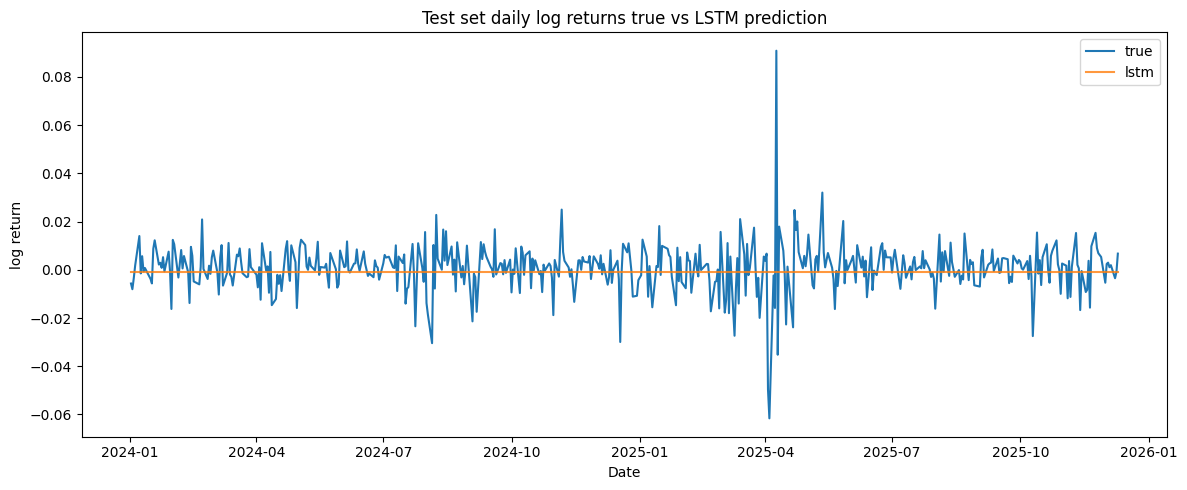

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_test_pred["date"], df_test_pred["y_true"], label="true")
plt.plot(df_test_pred["date"], df_test_pred["y_pred_lstm"], label="lstm", alpha=0.8)
plt.title("Test set daily log returns true vs LSTM prediction")
plt.xlabel("Date")
plt.ylabel("log return")
plt.legend()
plt.tight_layout()
plt.show()


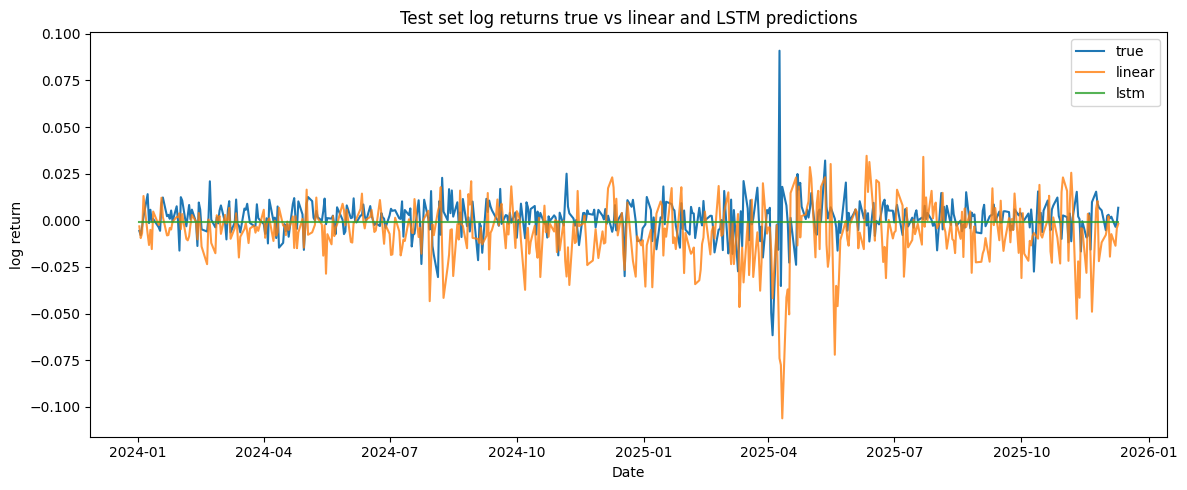

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(df_test_pred["date"], df_test_pred["y_true"], label="true")
plt.plot(df_test_pred["date"], df_test_pred["y_pred_lin"], label="linear", alpha=0.8)
plt.plot(df_test_pred["date"], df_test_pred["y_pred_lstm"], label="lstm", alpha=0.8)
plt.title("Test set log returns true vs linear and LSTM predictions")
plt.xlabel("Date")
plt.ylabel("log return")
plt.legend()
plt.tight_layout()
plt.show()


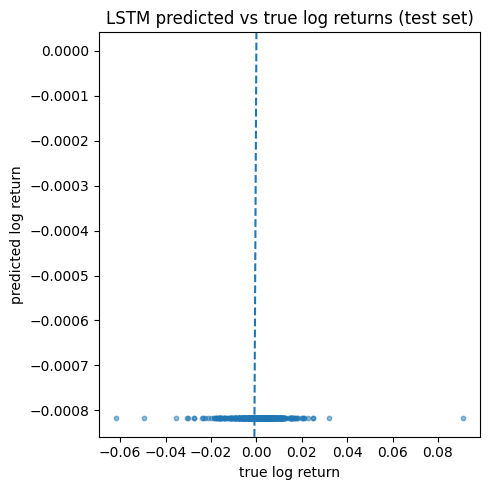

In [30]:
plt.figure(figsize=(5, 5))
plt.scatter(df_test_pred["y_true"], df_test_pred["y_pred_lstm"], s=10, alpha=0.5)
plt.axline((0, 0), slope=1.0, linestyle="--")
plt.title("LSTM predicted vs true log returns (test set)")
plt.xlabel("true log return")
plt.ylabel("predicted log return")
plt.tight_layout()
plt.show()


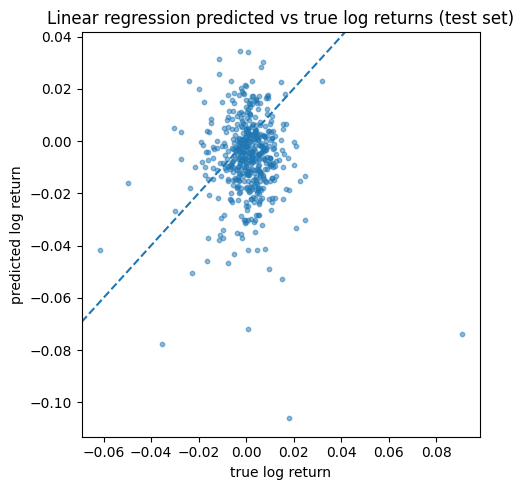

In [31]:
plt.figure(figsize=(5, 5))
plt.scatter(df_test_pred["y_true"], df_test_pred["y_pred_lin"], s=10, alpha=0.5)
plt.axline((0, 0), slope=1.0, linestyle="--")
plt.title("Linear regression predicted vs true log returns (test set)")
plt.xlabel("true log return")
plt.ylabel("predicted log return")
plt.tight_layout()
plt.show()


### LSTM training and validation loss curves


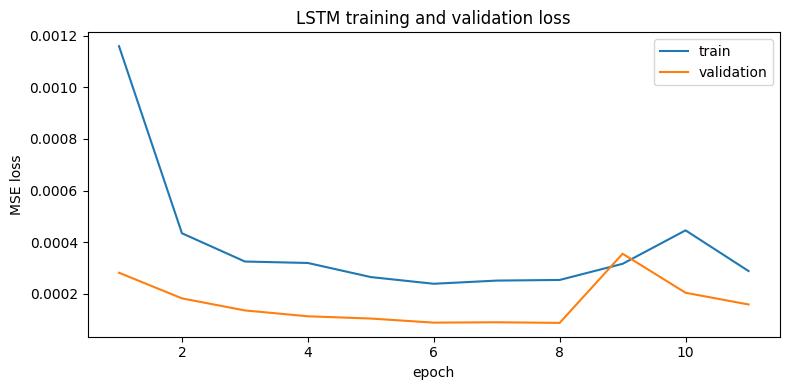

In [32]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_losses, label="train")
plt.plot(epochs_range, val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("LSTM training and validation loss")
plt.legend()
plt.tight_layout()
plt.show()


WindowsPath('../05_Results/lstm_train_val_loss.png')

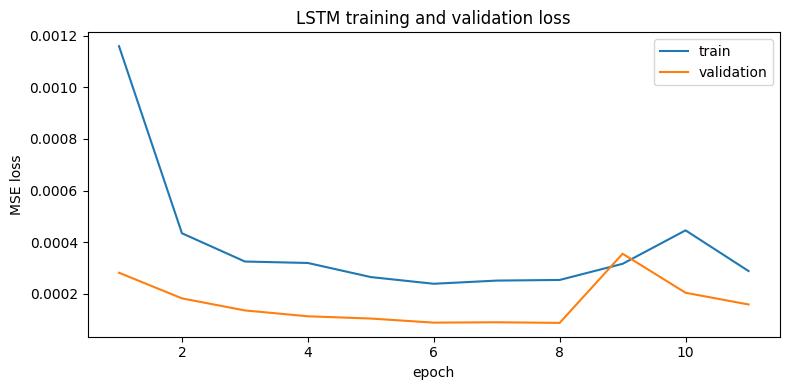

In [33]:
import os
from pathlib import Path

plots_dir = Path("../05_Results")
os.makedirs(plots_dir, exist_ok=True)

plot_path = plots_dir / "lstm_train_val_loss.png"
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_losses, label="train")
plt.plot(epochs_range, val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("LSTM training and validation loss")
plt.legend()
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plot_path
